**Coding Resources**
- https://github.com/lestercardoz11/SP-500-index-anomaly-detection 
- https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/ 

In [83]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

**S&P500 Daily Prices 1986-2018**
--description--

In [84]:
filepath = './data/spx.csv'
df = pd.read_csv(filepath)
print(df.shape)
df.head()

(8192, 2)


,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


**Visualize Data**

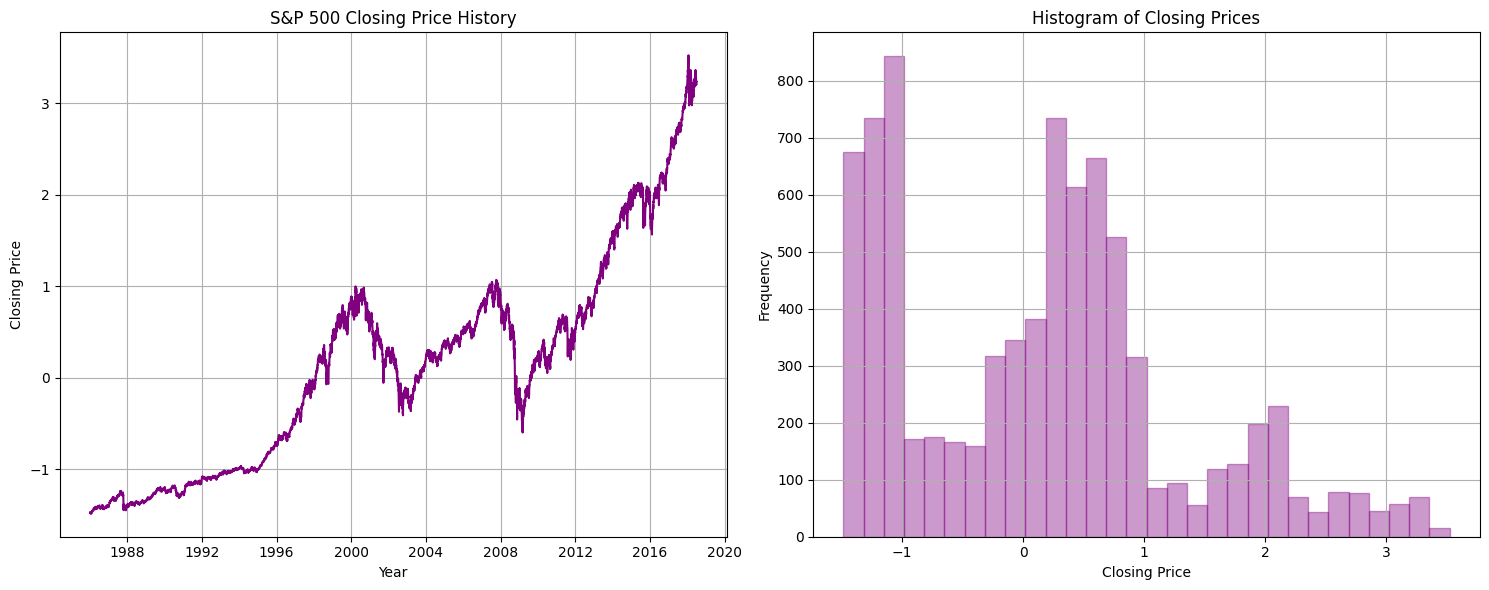

In [88]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# plot time series data
ax1.plot(df['date'], df['close'], color='purple')
ax1.set_xlabel('Year')
ax1.set_ylabel('Closing Price')
ax1.set_title('S&P 500 Closing Price History')
ax1.grid(True)

# plot histogram
ax2.hist(df['close'], bins=30, color='purple', edgecolor='purple', alpha=0.4, histtype='bar')
ax2.set_title('Histogram of Closing Prices')
ax2.set_xlabel('Closing Price')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Split & Standardize Data**

In [86]:
# split data
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 2) (410, 2)


In [87]:
# scalar fit to training data
scaler = StandardScaler()
scaler.fit(train[['close']])

# standardize train and test data
train.loc[:, 'close'] = scaler.transform(train[['close']])
test.loc[:, 'close'] = scaler.transform(test[['close']])
print("Train Mean:", train['close'].mean(), "Train Standard Deviation:", train['close'].std())
print("Test Mean:", test['close'].mean(), "Test Standard Deviation:", test['close'].std())

Train Mean: 3.5061476552541565e-16 Train Standard Deviation: 1.0000642570281786
Test Mean: 2.8503784420683367 Test Standard Deviation: 0.32960277554289286


**Pytorch Dataset**

**Model**

**Training**

**Evaluation**